<a href="https://colab.research.google.com/github/data-ted/myproject/blob/main/Yoco_Twitter_Sentiment_Analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yoco Twitter Sentiment Analyser**


![preview](https://cdn.pixabay.com/photo/2013/06/07/09/53/twitter-117595_960_720.png)
![preview](https://a.storyblok.com/f/111633/x/27e7ca327e/yoco-logo.svg)



This is a quick and dirty way to get a sense of what's trending on Twitter related to a particular Topic. For my use case, I am focusing on the Yoco in general, but you can easily apply this to any topic.

**Use the GPU for this notebook to speed things up:** select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE".

The code in this notebook does the following things:


*   Scrapes Tweets related to the Topic you are interested in.
*   Extracts relevant Tags from the text (NER: Named Entity Recognition).
*   Does Sentiment Analysis on those Tweets.
*   Provides some visualizations in an interactive format to get a 'pulse' of what's happening.

We use Tweepy to scrape Twitter data and Flair to do NER / Sentiment Analysis. We use Seaborn for visualizations and all of this is possible because of the wonderful, free and fast (with GPU) Google Colab.

**A bit about (Named Entity Recognition - NER )** 

This is the process of extracting labels form text. 

So, take an example sentence: 'George Washington went to Washington'. NER will allow us to extract labels such as Person for 'George Washington' and Location for 'Washington (state)'. It is one of the most common and useful applications in NLP and, using it, we can extract labels from Tweets and do analysis on them.

**A bit about Sentiment Analysis** 

Most commonly, this is the process of getting a sense of whether some text is Positive or Negative. More generally, you can apply it to any label of your choosing (Spam/No Spam etc.).

So, 'I hated this movie' would be classified as a negative statement but 'I loved this movie' would be classified as positive. Again - it is a very useful application as it allows us to get a sense of people's opinions about something (Twitter topics, Movie reviews etc). 

To learn more about these applications, check out the Flair Github homepage and Tutorials: https://github.com/zalandoresearch/flair


Note: You will need Twitter API keys (and of course a Twitter account) to make this work. You can get those by signing up here: https://developer.twitter.com/en/apps

To get up and running, we need to import a bunch of stuff and install Flair. Run through the next 3 cells.

In [1]:
# import lots of stuff
import sys
import os
import re
import tweepy
from tweepy import OAuthHandler
from textblob import TextBlob

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import clear_output
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
# install Flair
!pip install --upgrade git+https://github.com/flairNLP/flair.git

clear_output()

In [3]:
# import Flair stuff
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

clear_output()

In [4]:
#import Flair Classifier
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

clear_output()

### Authenticate with Twitter API

In [ ]:
#My Twitter API Authentication Variables
#consumer_key = 'xBr1NFh8v7ZKcOanILMgqfMid'
#consumer_secret = 'bTWfavPBLGbTpu3lyEqWEDKjsAvaU9FTTDR74NHu5yzfGez5Jg'
#access_token = '1563935335-DmYDiTnos39FuoWJvQ0nDL5Q5criGeHFyHw66Zd'
#access_token_secret = 'Nr1013tM2zo6mSnDKIyYsYh2anz5OU5Hps8flcujFO95J'

In [7]:
#@title Enter Twitter Credentials
TWITTER_KEY = 'xBr1NFh8v7ZKcOanILMgqfMid' #@param {type:"string"}
TWITTER_SECRET_KEY = 'bTWfavPBLGbTpu3lyEqWEDKjsAvaU9FTTDR74NHu5yzfGez5Jg' #@param {type:"string"}

In [8]:
# Authenticate
auth = tweepy.AppAuthHandler(TWITTER_KEY, TWITTER_SECRET_KEY)

api = tweepy.API(auth, wait_on_rate_limit=True,
				   wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)


###Lets start scraping!

The Twitter scrape code here was taken from: https://bhaskarvk.github.io/2015/01/how-to-use-twitters-search-rest-api-most-effectively.

Shoutout to the author.👌🏾😊

We need to provide a Search term and a Max Tweet count. Twitter lets you to request 45,000 tweets every 15 minutes  so setting something below that works.

In [68]:
#@title Twitter Search API Inputs
#@markdown ### Enter Search Query:
searchQuery = 'yoco_za' #@param {type:"string"}
#@markdown ### Enter Max Tweets To Scrape:
#@markdown #### The Twitter API Rate Limit (currently) is 45,000 tweets every 15 minutes.
maxTweets = 6200 #@param {type:"slider", min:0, max:45000, step:100}
Filter_Retweets = True #@param {type:"boolean"}

tweetsPerQry = 100  # this is the max the API permits
tweet_lst = []

if Filter_Retweets:
  searchQuery = searchQuery + ' -filter:retweets'  # to exclude retweets

# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -10000000000

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
while tweetCount < maxTweets:
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang="en")
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", since_id=sinceId)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1))
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                        lang="en", max_id=str(max_id - 1),
                                        since_id=sinceId)
        if not new_tweets:
            print("No more tweets found")
            break
        for tweet in new_tweets:
          if hasattr(tweet, 'reply_count'):
            reply_count = tweet.reply_count
          else:
            reply_count = 0
          if hasattr(tweet, 'retweeted'):
            retweeted = tweet.retweeted
          else:
            retweeted = "NA"
            
          # fixup search query to get topic
          topic = searchQuery[:searchQuery.find('-')].capitalize().strip()
          
          # fixup date
          tweetDate = tweet.created_at.date()
          
          tweet_lst.append([tweetDate, topic, 
                      tweet.id, tweet.user.screen_name, tweet.user.name, tweet.text, tweet.favorite_count, 
                      reply_count, tweet.retweet_count, retweeted])

        tweetCount += len(new_tweets)
        print("Downloaded {0} tweets".format(tweetCount))
        max_id = new_tweets[-1].id
    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

clear_output()
print("Downloaded {0} tweets".format(tweetCount))

Downloaded 445 tweets


##Data Analysis

Let's load the tweet data into a Pandas Dataframe so we can do Data Analysis to it. 

The data is also saved down in a tweets.csv file in case you want to download it.

In [80]:
pd.set_option('display.max_colwidth', -1)

# load it into a pandas dataframe
tweet_df = pd.DataFrame(tweet_lst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'like_count', 'reply_count', 'retweet_count', 'retweeted'])
tweet_df.to_csv('tweets.csv')
tweet_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,tweet_dt,topic,id,username,name,tweet,like_count,reply_count,retweet_count,retweeted
0,2021-12-14,Yoco_za,1470658879642124293,Phat_Sii,Siphumelelo Kwinana,"Hey Business owners don't miss out on December sales, head to https://t.co/ONESsrIunr and use their tips to pivot a… https://t.co/gc3kJGR9uL",0,0,0,False
1,2021-12-14,Yoco_za,1470654287298633730,Phat_Sii,Siphumelelo Kwinana,Consistency is very important 👌 \n#CheckIn @Yoco_ZA https://t.co/R5w5cYueKQ,1,0,0,False
2,2021-12-14,Yoco_za,1470651843948818434,mpumiglobal,Mpumelelo Ndiweni,@RovertPtyLtd @katlegomaphai @Yoco_ZA @JacobBW10 @thebulbworldBW @selfstyledking Keep shining champs 👏🏿,1,0,1,False
3,2021-12-14,Yoco_za,1470651561403629568,RovertPtyLtd,Rovert Investments.,@mpumiglobal @katlegomaphai @Yoco_ZA @JacobBW10 @thebulbworldBW @selfstyledking Thank you Mpumi.,0,0,0,False
4,2021-12-14,Yoco_za,1470649927571283969,DimakatsoS05,Thabiso 😍💚,"@Yoco_ZA I learned things like taking risks, being patient, making sacrifices, &amp; being consistent is key 🗝️😁\n#Checkin @Yoco_ZA",1,0,0,False


Unfortunately Twitter does not let you filter by date when you request tweets. However, we can do this at this stage. I have set it up to pull yesterday + todays Tweets by default.

In [70]:
#@title Filter By Date Range
today = datetime.now().date()
yesterday = today - timedelta(1)

start_dt = '2021-12-01' #@param {type:"date"}
end_dt = '2021-12-15' #@param {type:"date"}

if start_dt == '':
  start_dt = yesterday
else:
  start_dt = datetime.strptime(start_dt, '%Y-%m-%d').date()

if end_dt == '':
  end_dt = today
else:
  end_dt = datetime.strptime(end_dt, '%Y-%m-%d').date()


tweet_df = tweet_df[(tweet_df['tweet_dt'] >= start_dt) 
                    & (tweet_df['tweet_dt'] <= end_dt)]
tweet_df.shape

(445, 10)

## NER and Sentiment Analysis

Now let's do some NER / Sentiment Analysis. We will use the Flair library: https://github.com/zalandoresearch/flair

###NER

Previosuly, we extracted, and then appended the Tags as separate rows in our dataframe. This helps us later on to Group by Tags.

We also create a new 'Hashtag' Tag as Flair does not recognize it and it's a big one in this context.

### Sentiment Analysis

We use the Flair Classifier to get Polarity and Result and add those fields to our dataframe.

**Warning:** This can be slow if you have lots of tweets.

In [71]:
# predict NER
nerlst = []

for index, row in tqdm(tweet_df.iterrows(), total=tweet_df.shape[0]):
  cleanedTweet = row['tweet'].replace("#", "")
  sentence = Sentence(cleanedTweet, use_tokenizer=True)
  
  # predict NER tags
  tagger.predict(sentence)

  # get ner
  ners = sentence.to_dict(tag_type='ner')['entities']
  
  # predict sentiment
  classifier.predict(sentence)
  
  label = sentence.labels[0]
  response = {'result': label.value, 'polarity':label.score}
  
  # get hashtags
  hashtags = re.findall(r'#\w+', row['tweet'])
  if len(hashtags) >= 1:
    for hashtag in hashtags:
      ners.append({ 'type': 'Hashtag', 'text': hashtag })
  
  for ner in ners:
    adj_polarity = response['polarity']
    if response['result'] == 'NEGATIVE':
      adj_polarity = response['polarity'] * -1
    try:
      ner['type']
    except:
      ner['type'] = ''      
    nerlst.append([ row['tweet_dt'], row['topic'], row['id'], row['username'], 
                   row['name'], row['tweet'], ner['type'], ner['text'], response['result'], 
                   response['polarity'], adj_polarity, row['like_count'], row['reply_count'], 
                  row['retweet_count'] ])

clear_output()

In [72]:
df_ner = pd.DataFrame(nerlst, columns=['tweet_dt', 'topic', 'id', 'username', 'name', 'tweet', 'tag_type', 'tag', 'sentiment', 'polarity', 
                                       'adj_polarity','like_count', 'reply_count', 'retweet_count'])
df_ner.head()

,tweet_dt,topic,id,username,name,tweet,tag_type,tag,sentiment,polarity,adj_polarity,like_count,reply_count,retweet_count
0,2021-12-14,Yoco_za,1470654287298633730,Phat_Sii,Siphumelelo Kwinana,Consistency is very important 👌 \n#CheckIn @Yoco_ZA https://t.co/R5w5cYueKQ,Hashtag,#CheckIn,POSITIVE,0.990137,0.990137,1,0,0
1,2021-12-14,Yoco_za,1470651561403629568,RovertPtyLtd,Rovert Investments.,@mpumiglobal @katlegomaphai @Yoco_ZA @JacobBW10 @thebulbworldBW @selfstyledking Thank you Mpumi.,,Mpumi,POSITIVE,0.823589,0.823589,0,0,0
2,2021-12-14,Yoco_za,1470649927571283969,DimakatsoS05,Thabiso 😍💚,"@Yoco_ZA I learned things like taking risks, being patient, making sacrifices, &amp; being consistent is key 🗝️😁\n#Checkin @Yoco_ZA",,ZA,POSITIVE,0.718522,0.718522,1,0,0
3,2021-12-14,Yoco_za,1470649927571283969,DimakatsoS05,Thabiso 😍💚,"@Yoco_ZA I learned things like taking risks, being patient, making sacrifices, &amp; being consistent is key 🗝️😁\n#Checkin @Yoco_ZA",Hashtag,#Checkin,POSITIVE,0.718522,0.718522,1,0,0
4,2021-12-14,Yoco_za,1470645849856397312,ThembiThemba,Thembisile Sambo🇿🇦,@Yoco_ZA Building hurts.,,Yoco,NEGATIVE,0.999963,-0.999963,0,0,0


Let's filter out obvious tags like #Yoco that would show up for this search. You can comment this portion out or use different Tags for your list.

In [81]:
# filter out obvious tags
banned_words = ['Yoco', 'ZA', '#South Africa', '#YOCO', 'yoco', 'yoco_za', 'YOCO_ZA',
                'yoco za', 'South Africa ZA', 'Southern Africa','ZA Google', 'ZA ', 'Hi ', 
                'ZA I, ZA Nice']

df_ner = df_ner[~df_ner['tag'].isin(banned_words)]

Calculate Frequency, Likes, Replies, Retweets and Average Polarity per Tag.

In [82]:
ner_groups = df_ner.groupby(['tag', 'tag_type']).agg({'tag': "count", 'adj_polarity': "mean",
                                                     'like_count': 'sum', 'reply_count': 'sum',
                                                     'retweet_count': 'sum'})
ner_groups = ner_groups.rename(columns={
    "tag": "Frequency",
    "adj_polarity": "Avg_Polarity",
    "like_count": "Total_Likes",
    "reply_count": "Total_Replies",
    "retweet_count": "Total_Retweets"
})
ner_groups = ner_groups.sort_values(['Frequency'], ascending=False)
ner_groups = ner_groups.reset_index()
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets
0,Mahlangu,,50,0.746675,222,0,46
1,Yoco's,,20,0.569382,3,0,0
2,#RiseTheUnderdog,Hashtag,17,0.977541,98,0,57
3,#MyYoco,Hashtag,12,0.765595,3,0,0
4,#FlipToYoco,Hashtag,8,-0.295569,114,0,148


Create an overall Sentiment column based on the Average Polarity of the Tag.

In [83]:
ner_groups['Sentiment'] = np.where(ner_groups['Avg_Polarity']>=0, 'POSITIVE', 'NEGATIVE')
ner_groups.head()

,tag,tag_type,Frequency,Avg_Polarity,Total_Likes,Total_Replies,Total_Retweets,Sentiment
0,Mahlangu,,50,0.746675,222,0,46,POSITIVE
1,Yoco's,,20,0.569382,3,0,0,POSITIVE
2,#RiseTheUnderdog,Hashtag,17,0.977541,98,0,57,POSITIVE
3,#MyYoco,Hashtag,12,0.765595,3,0,0,POSITIVE
4,#FlipToYoco,Hashtag,8,-0.295569,114,0,148,NEGATIVE


## Visualize!

We can get some bar plots for the Tags based on the following metrics:



*   Most Popular Tweets
*   Most Liked Tweets
*   Most Replied Tweets
*   Most Retweeted Tweets

By default, we do the analysis on all the Tags but we can also filter by Tag by checking the Filter_TAG box. 
This way we can further drill down into the metrics for Hashtags, Persons, Locations & Organizations.

We cut the plots by Sentiment i.e. the color of the bars tells us if the overall Sentiment was Positive or Negative.


Text(0.5, 0, '')

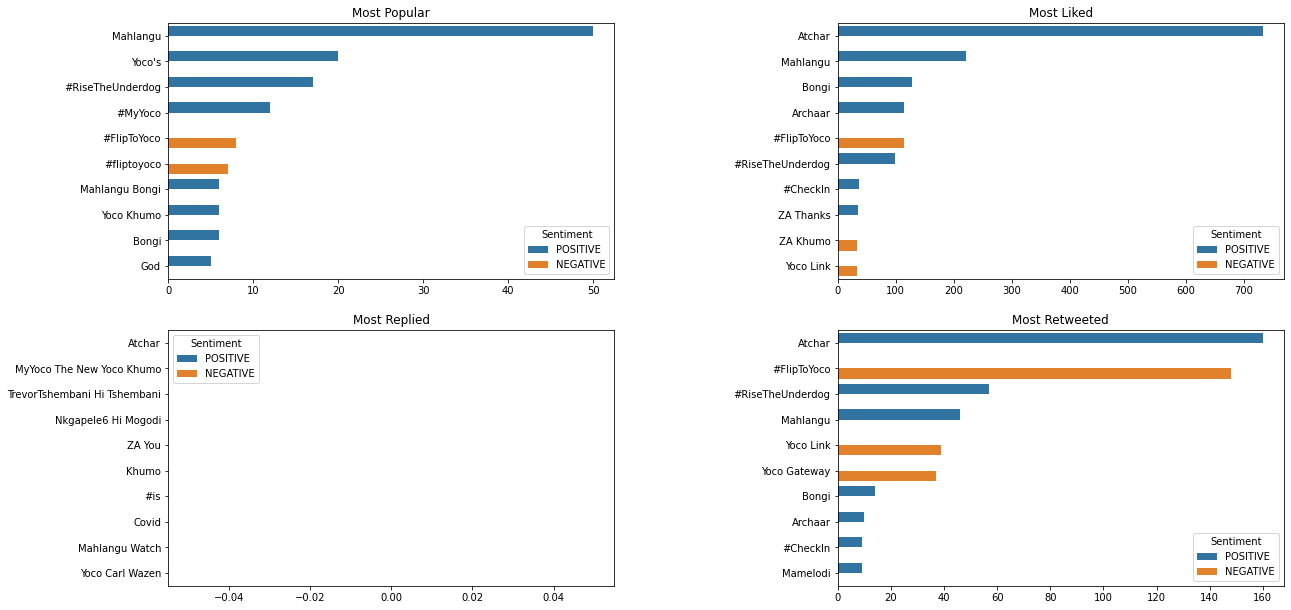

In [84]:
#@title Visualize Top TAGs
Filter_TAG = False #@param {type:"boolean"}
TAG = 'Person' #@param ["Hashtag", "Person", "Location", "Organization"]
#@markdown ###Pick how many tags to display per chart:
Top_N = 10 #@param {type:"integer"}

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

# plot the figures
fig = plt.figure(figsize=(20, 16))
fig.subplots_adjust(hspace=0.2, wspace=0.5)

ax1 = fig.add_subplot(321)
sns.barplot(x="Frequency", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax2 = fig.add_subplot(322)
filtered_group = filtered_group.sort_values(['Total_Likes'], ascending=False)
sns.barplot(x="Total_Likes", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax3 = fig.add_subplot(323)
filtered_group = filtered_group.sort_values(['Total_Replies'], ascending=False)
sns.barplot(x="Total_Replies", y="tag", data=filtered_group[:Top_N], hue="Sentiment")
ax4 = fig.add_subplot(324)
filtered_group = filtered_group.sort_values(['Total_Retweets'], ascending=False)
sns.barplot(x="Total_Retweets", y="tag", data=filtered_group[:Top_N], hue="Sentiment")

ax1.title.set_text('Most Popular')
ax2.title.set_text('Most Liked')
ax3.title.set_text('Most Replied')
ax4.title.set_text('Most Retweeted')

ax1.set_ylabel('')    
ax1.set_xlabel('')
ax2.set_ylabel('')    
ax2.set_xlabel('')
ax3.set_ylabel('')    
ax3.set_xlabel('')
ax4.set_ylabel('')    
ax4.set_xlabel('')

###Get the Average Polarity Distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


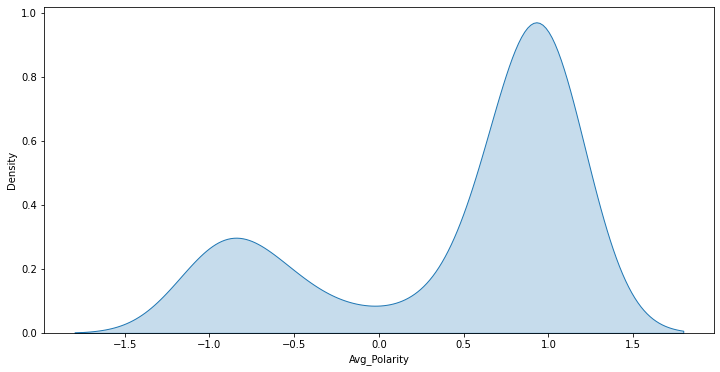

In [85]:
fig = plt.figure(figsize=(12, 6))
sns.distplot(filtered_group['Avg_Polarity'], hist=False, kde_kws={"shade": True})

## Word Cloud

Let's build a Word Cloud based on these metrics. 

Since I am interested in South Africa, I am going to use overlay the table mountain view over my Word Cloud. 
You can change this by selecting a different Mask option from the drop down.

Images for Masks can be found at:

http://clipart-library.com/clipart/2099977.htm

https://needpix.com

In [78]:
# download mask images
!wget http://clipart-library.com/img/2099977.jpg -O city.jpg
!wget https://storage.needpix.com/rsynced_images/trotting-horse-silhouette.jpg -O horse.jpg
!wget https://storage.needpix.com/rsynced_images/black-balloon.jpg -O balloon.jpg
  
clear_output()

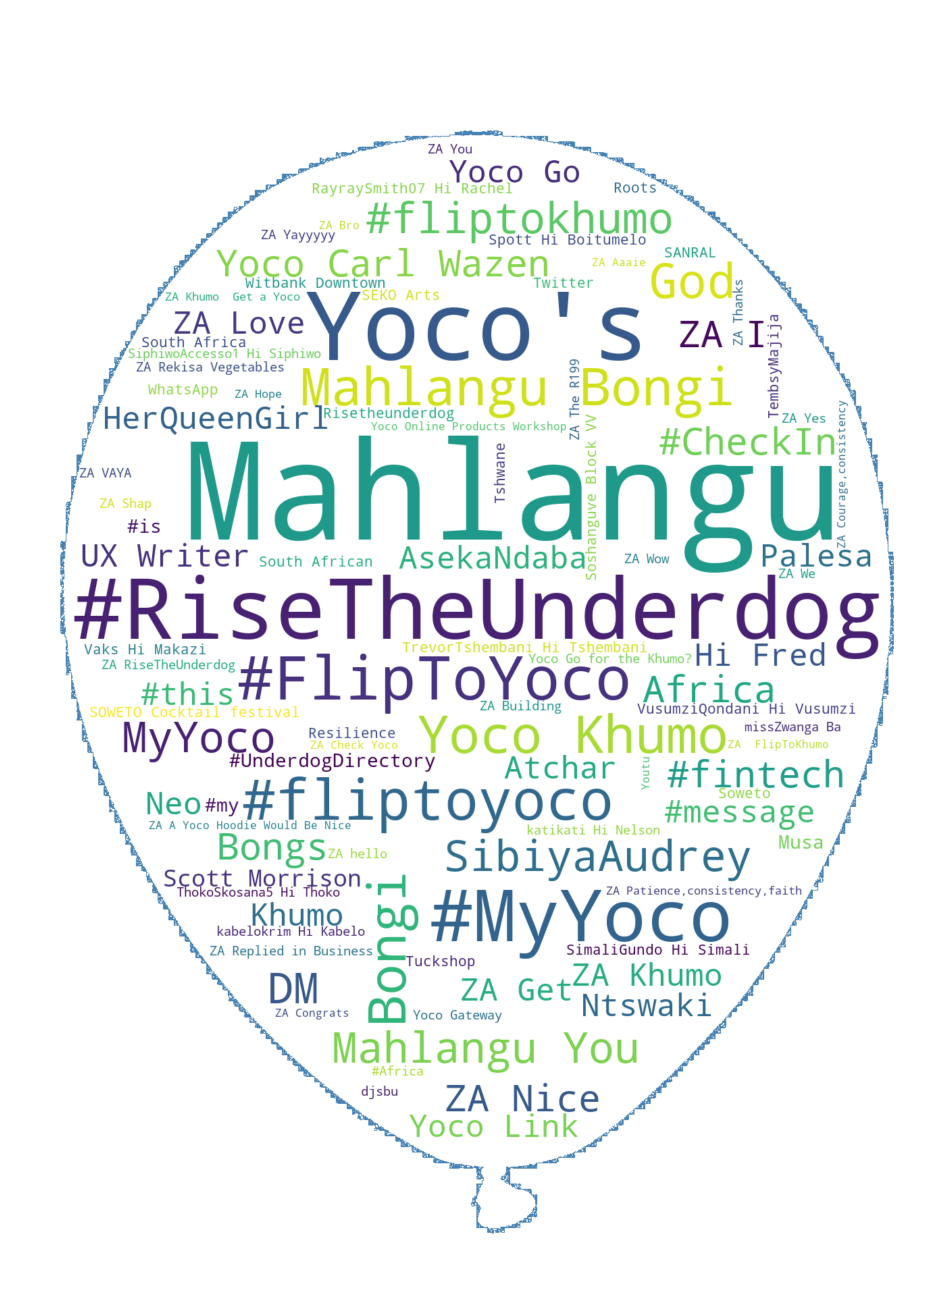

In [86]:
#@title Build Word Cloud For Top TAGs
Metric = 'Most Popular' #@param ["Most Popular", "Most Liked", "Most Replied", "Most Retweeted"]
#@markdown
Filter_TAG = False #@param {type:"boolean"}
##@markdown
TAG = 'Location' #@param ["Hashtag", "Person", "Location", "Organization"]
Mask = 'Balloon' #@param ["Rectangle", "City", "Balloon", "Horse"]

# get correct Metric value
if Metric == 'Most Popular':
   Metric = 'Frequency'
elif Metric == 'Most Liked':
   Metric = 'Total_Likes'
elif Metric == 'Most Replied':
   Metric = 'Total_Replies'
elif Metric == 'Most Retweeted':
   Metric = 'Total_Retweets'    

# get TAG value
if TAG != 'Hashtag':
  TAG = TAG[:3].upper()

if Filter_TAG:
  filtered_group = ner_groups[(ner_groups['tag_type'] == TAG)]
else:
  filtered_group = ner_groups

countDict = {}

for index, row in filtered_group.iterrows():
  if row[Metric] == 0:
    row[Metric] = 1
  countDict.update( {row['tag'] : row[Metric]} )
  
if Mask == 'Seattle':
  Mask = np.array(Image.open("seattle.jpg"))
elif Mask == 'Rectangle':
  Mask = np.array(Image.new('RGB', (800,600), (0, 0, 0)))
elif Mask == 'Horse':
  Mask = np.array(Image.open("horse.png"))
elif Mask == 'Balloon':
  Mask = np.array(Image.open("balloon.jpg"))

clear_output()

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=100,
#     max_font_size=50,
    height=300,
    width=800,
    background_color = 'white',
    mask=Mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords = STOPWORDS).generate_from_frequencies(countDict)
fig = plt.figure(
    figsize = (18, 18),
    )
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()